# Durable Consumption Model

**Table of contents**<a id='toc0_'></a>    
- 1. [Model equations](#toc1_)    
- 2. [Overview](#toc2_)    
- 3. [Setup](#toc3_)    
  - 3.1. [Choose number of threads in numba](#toc3_1_)    
- 4. [Settings](#toc4_)    
- 5. [NVFI - nested value function iteration](#toc5_)    
- 6. [NEGM - nested endogenous grid method](#toc6_)    
- 7. [Compare life-cycles from NVFI and NEGM](#toc7_)    
- 8. [Compare life-cycle profiles with VFI](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

This notebooks shows you how to use the tools of the **consav** package to solve a **durable consumption model** with either

1. **vfi**: standard value function iteration (written in C++)
2. **nvfi**: nested value function iteration (writen in Python, or **nvfi_cpp** is written i C++)
3. **negm**: nested endogenous grid point method (writen in Python, or **negm_cpp** is written i C++)

The implemented solution methods are explained in detail in [A Guide to Solve Non-Convex Consumption-Saving Models](https://doi.org/10.1007/s10614-020-10045-x).

**Computer used for timings:** Windows 10 computer with 2x Intel(R) Xeon(R) Gold 6254 3.10 GHz CPUs (18 cores, 36 logical processes each) and 768 GB of RAM.

## 1. <a id='toc1_'></a>[Model equations](#toc0_)

The **states** are:

1. the persistent component of income, $p_t$
2. stock of the durable good, $n_t$
3. cash-on-hand, $m_t$

The **choices** are:

1. durable consumption, $d_t$
2. non-durable consumption, $c_t$

**Utility** is CRRA over a Cobb-Douglas aggregate:

$$ u(c_{t},d_{t})=\frac{(c_{t}^{\alpha}(d_{t}+\underline{d})^{1-\alpha})^{1-\rho}}{1-\rho} $$

**Income** follows a persistent-transitory process:

$$
\begin{aligned}
p_{t+1}&=\psi_{t+1}p_{t}^{\lambda},\,\,\,\log\psi_{t+1}\sim\mathcal{N}(-0.5\sigma_{\psi}^{2},\sigma_{\psi}^{2}) \\ y_{t+1}&=\xi_{t+1}p_{t+1},\,\,\,\log\xi_{t+1}\sim\mathcal{N}(-0.5\sigma_{\xi}^{2},\sigma_{\xi}^{2})
\end{aligned} 
$$

The household **cannot borrow** and the **interest rate** on savings is $r$. Adjusting the stock of durables is subject to a **proportional adjustment cost** $\tau$ and **durables depreciates** with a rate of $\delta$.

$$ n_{t+1}=(1-\delta)d_{t} $$

The **bellman equation** is

$$
\begin{aligned}
v_{t}(p_{t},n_{t},m_{t})&=\max\{v_{t}^{keep}(p_{t},n_{t},m_{t}),v_{t}^{adj.}(p_{t},x_{t})\}\\&\text{s.t.}&\\x_{t}&=&m_{t}+(1-\tau)n_{t}
\end{aligned} 
$$

 where
 
$$
\begin{aligned}
v_{t}^{keep}(p_{t},n_{t},m_{t})&=\max_{c_{t}}u(c_{t},n_{t})+\beta\mathbb{E}_{t}[v_{t+1}(p_{t+1},n_{t+1},m_{t+1})]\\&\text{s.t.}&\\
a_{t}&= m_{t}-c_{t}\\
m_{t+1}&= (1+r)a_{t}+y_{t+1}\\
n_{t+1}&= (1-\delta)n_{t}\\
a_{t}&\geq 0
\end{aligned} 
$$

and
 
$$
\begin{aligned}
v_{t}^{adj.}(p_{t},x_{t})&= \max_{c_{t},d_{t}}u(c_{t},d_{t})+\beta\mathbb{E}_{t}[v_{t+1}(p_{t+1},n_{t+1},m_{t+1})]\\&\text{s.t.}&\\
a_{t}&= x_{t}-c_{t}-d_{t}\\
m_{t+1}&= (1+r)a_{t}+y_{t+1}\\ 
n_{t+1}&= (1-\delta)n_{t}\\
a_{t}&\geq 0
\end{aligned} 
$$


## 2. <a id='toc2_'></a>[Overview](#toc0_)

The model solved in this notebook is written in **DurableConsumptionModelModel.py**. 

It provides a class called **DurableConsumptionModelClass** inheriting its basic interface from the **ModelClass**. 

A short **overview** of the interface is:

1. The class must have a **name** and must contain **three central methods**: 

    1. `settings()` Choose fundamental settings (called *first* when initializing).
    
        1. `namespaces (list of str)`: In addition to `.par`, `.sol`, `.sim`, each element will be available as an attribute (can be used in numba jitted functions).
        2. `other_attrs (list of str)`: Other attributes to be saved (can *not* be used in numba jitted functions).
        3. `savefolder (str)`: Folder to save the model in.
        4. `not_float list of str)`: List of non-float elements in the namespaces (ensures safe type inference).<br><br>
        
    2. `setup()`: Set baseline parameters (called *second* when initializing).
    3. `allocate()`: Create grids and allocate solution and simulation memory (called *third* when initializing).

2. **Type-inference:** When initializing the model the `settings()`, `setup()` and `allocate()` methods are called, and the types of all variables in the namespaces are inferred. Results can be seen by `print(model)`. *Types and number of dimensions in arrays must not change afterwards.* 
3. The **solve()** method solves the model
4. The **simulate()** method simulates the model
5. The **save()** method saves the model naming it **savefolder/name**
6. The **copy()** makes a deep copy of the model

In addition to **DurableConsumptionModel.py**, this folder contains the following files:

1. **last_period.py**: calculate consumption and value function in last period
2. **utility.py**: utility function and marginal utility function
3. **trans.py**: state transition functions
4. **post_decision.py**: calcualte $w$ and $q$
5. **nvfi.py**: solve with nested value function iteration
6. **negm.py**: solve with the nested endogenous grid method
7. **simulate.py**: simulate for all solution methods
8. **figs.py**: plot figures
9. **tabs.py**: prints tables in .tex files

The functions in these modules are loaded in **DurableConsumptionModel.py**.

The folder **cppfuncs** contains C++ functions not used in this notebook.

## 3. <a id='toc3_'></a>[Setup](#toc0_)

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np

# load the DurableConsumptionModel module
from DurableConsumptionModel import DurableConsumptionModelClass

### 3.1. <a id='toc3_1_'></a>[Choose number of threads in numba](#toc0_)

In [2]:
import numba as nb
nb.set_num_threads(8)

## 4. <a id='toc4_'></a>[Settings](#toc0_)

Choose number of periods to solve:

In [3]:
T = 5

## 5. <a id='toc5_'></a>[NVFI - nested value function iteration](#toc0_)

Define the **post-decision value function** as

$$ w_{t}(p_{t},n_{t},a_{t}) = \beta \mathbb{E}_{t}[v_{t+1}(m_{t+1},n_{t+1},p_{t+1})] $$

The **keeper problem** can then be written:

$$
\begin{aligned}
v_{t}^{keep}(p_{t},n_{t},m_{t})&=\max_{c_{t}}u(c_{t},n_{t})+ w_{t}(p_{t},n_{t},a_{t})]\\&\text{s.t.}&\\a_{t}&=&m_{t}-c_{t}\geq0
\end{aligned}
$$

The **adjuster problem** can further be written:

$$
\begin{aligned}
v_{t}^{adj.}(x_{t})&=\max_{d_{t}}v_{t}^{keep}(p_{t},d_{t},n_{t})\\&\text{s.t.}&\\m_{t}&=&x_{t}-d_{t}
\end{aligned}
$$

**NVFI** solves this reformulated problem.

In [4]:
model_nvfi = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'nvfi','T':T,'do_print':True})
print(model_nvfi)

Modelclass: DurableConsumptionModelClass
Name: example_negm

namespaces: ['par', 'sol', 'sim']
other_attrs: []
savefolder: saved
cpp_filename: cppfuncs/main.cpp

par:
 do_2d = False [bool]
 T = 5 [int]
 beta = 0.965 [float]
 rho = 2.0 [float]
 alpha = 0.9 [float]
 d_ubar = 0.01 [float]
 d1_ubar = 0.01 [float]
 d2_ubar = 0.01 [float]
 R = 1.03 [float]
 tau = 0.1 [float]
 tau1 = 0.08 [float]
 tau2 = 0.12 [float]
 delta = 0.15 [float]
 delta1 = 0.1 [float]
 delta2 = 0.2 [float]
 gamma = 0.5 [float]
 sigma_psi = 0.1 [float]
 Npsi = 5 [int]
 sigma_xi = 0.1 [float]
 Nxi = 5 [int]
 pi = 0.0 [float]
 mu = 0.5 [float]
 Np = 50 [int]
 p_min = 0.0001 [float]
 p_max = 3.0 [float]
 Nn = 50 [int]
 n_max = 3.0 [float]
 Nm = 100 [int]
 m_max = 10.0 [float]
 Nx = 100 [int]
 x_max = 13.0 [float]
 Na = 100 [int]
 a_max = 11.0 [float]
 sigma_p0 = 0.2 [float]
 mu_d0 = 0.8 [float]
 sigma_d0 = 0.2 [float]
 mu_a0 = 0.2 [float]
 sigma_a0 = 0.1 [float]
 simN = 100000 [int]
 sim_seed = 1998 [int]
 euler_cutoff =

In [5]:
model_nvfi.precompile_numba() # solve with very coarse grids
model_nvfi.solve()
model_nvfi.simulate()
model_nvfi.save()

numba precompiled in 29.4 secs
 t = 4 solved in 0.1 secs
  w computed in 0.0 secs


  solved keeper problem in 0.2 secs
  solved adjuster problem in 0.0 secs
 t = 3 solved in 0.3 secs
  w computed in 0.0 secs


  solved keeper problem in 0.2 secs
  solved adjuster problem in 0.0 secs
 t = 2 solved in 0.6 secs
  w computed in 0.0 secs


  solved keeper problem in 0.2 secs
  solved adjuster problem in 0.0 secs
 t = 1 solved in 0.9 secs
  w computed in 0.0 secs


  solved keeper problem in 0.2 secs
  solved adjuster problem in 0.0 secs
 t = 0 solved in 1.2 secs
model simulated in 0.1 secs
euler errors calculated in 0.0 secs
utility calculated in 0.0 secs


**Plot** interactive decision functions:

In [6]:
#model_nvfi.decision_functions()

**Plot** life-cycle profiles:

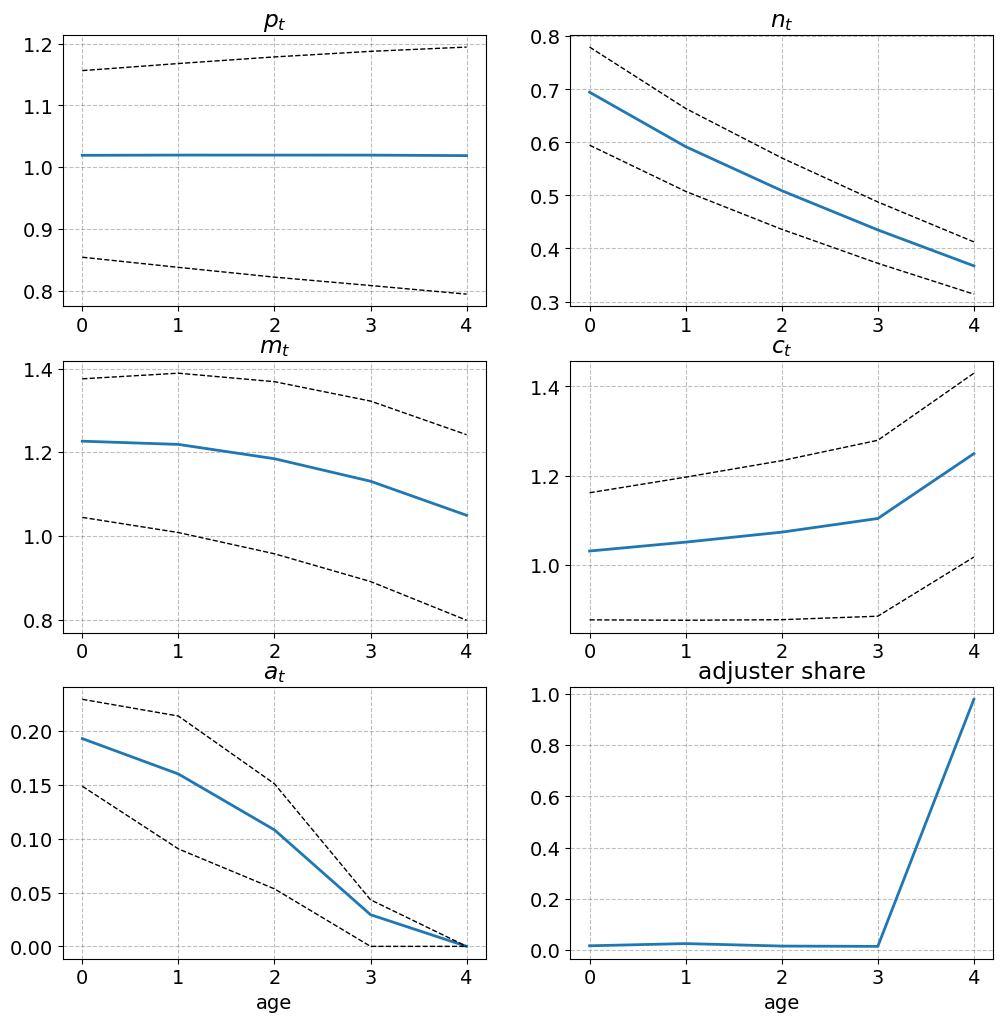

In [7]:
model_nvfi.lifecycle()

## 6. <a id='toc6_'></a>[NEGM - nested endogenous grid method](#toc0_)

Define the **post-decision marginal value of cash:**

$$
\begin{aligned}
q_{t}(p_{t},d_{t},a_{t})&=\beta R\mathbb{E}_{t}[u_{c}(c_{t+1},d_{t+1})]\\
&=&\beta R\mathbb{E}_{t}[\alpha c_{t+1}^{\alpha(1-\rho)-1}d_{t+1}^{(1-\alpha)(1-\rho)}]
\end{aligned}
$$

Note that all optimal interior consumption choices must satisfy the **Euler-equation**

$$
\begin{aligned}
u_{c}(c_{t},d_{t})=\alpha c_{t}^{\alpha(1-\rho)-1}d_{t}^{(1-\alpha)(1-\rho)}&=q(p_{t},d_{t},a_{t})
\end{aligned}
$$

This implies that we have an analytical mapping from the post-decision space $(p_t,d_t,a_t)$ to consumption and cash-on-hand $(c_t,m_t)$:

$$
\begin{aligned}
c_{t} &=\frac{1}{\alpha}\left(\frac{q(a_{t},d_{t},p_{t})}{d_{t}^{(1-\alpha)(1-\rho)}}\right)^{\alpha(1-\rho)-1}
\\
m_{t} &= a_{t}+c_{t}
\end{aligned}
$$

**NEGM** uses this mapping (and an upperenvelope algorithm) to solve the keeper problem much faster.

In [8]:
model_negm = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','T':T,'do_print':True})
model_negm.precompile_numba() # solve with very coarse grids
model_negm.solve()
model_negm.simulate()
model_negm.save()

numba precompiled in 35.5 secs
 t = 4 solved in 0.1 secs
  w computed in 0.1 secs
  solved keeper problem in 0.0 secs
  solved adjuster problem in 0.0 secs
 t = 3 solved in 0.2 secs


  w computed in 0.1 secs
  solved keeper problem in 0.0 secs
  solved adjuster problem in 0.0 secs
 t = 2 solved in 0.3 secs
  w computed in 0.1 secs
  solved keeper problem in 0.0 secs
  solved adjuster problem in 0.0 secs
 t = 1 solved in 0.4 secs


  w computed in 0.1 secs
  solved keeper problem in 0.0 secs
  solved adjuster problem in 0.0 secs
 t = 0 solved in 0.5 secs
model simulated in 0.1 secs
euler errors calculated in 0.0 secs
utility calculated in 0.0 secs


**Plot** interactive decision functions:

In [9]:
#model_negm.decision_functions()

**Plot** life-cycle profiles:

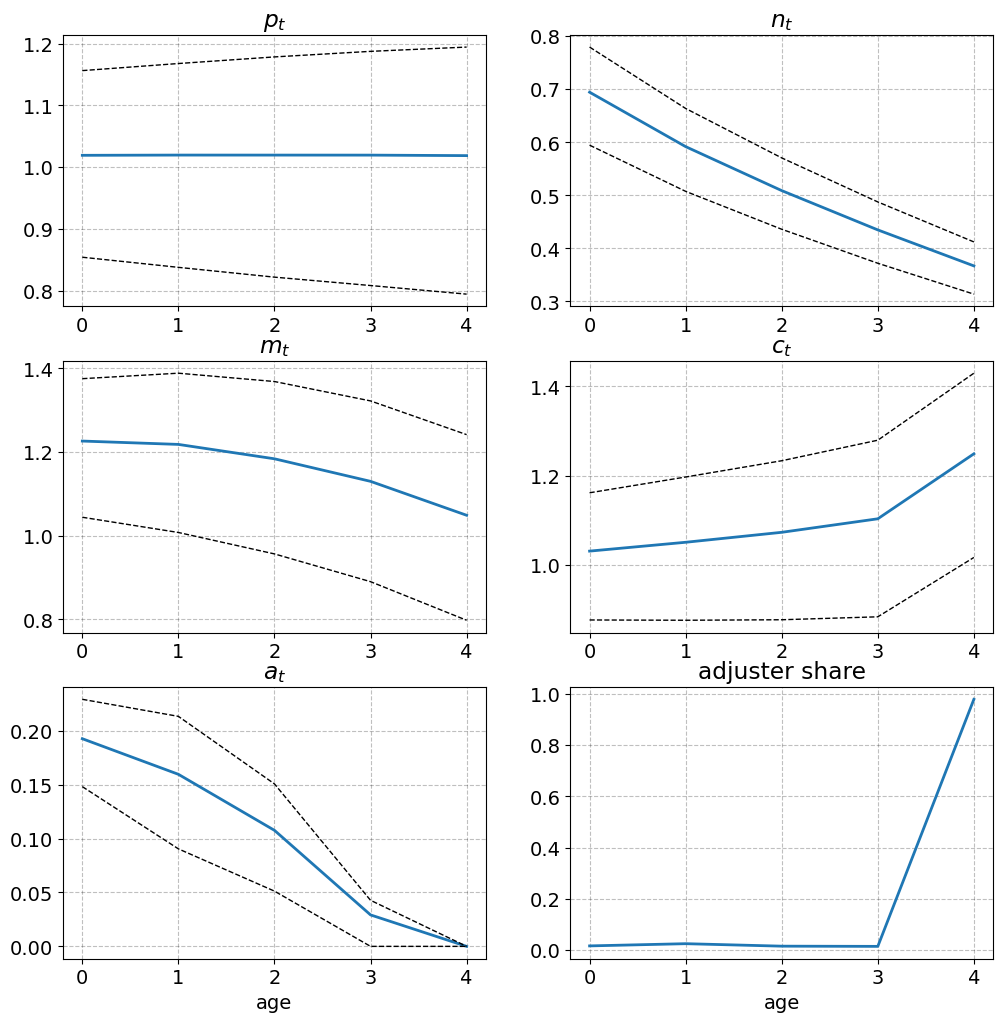

In [10]:
model_negm.lifecycle()

## 7. <a id='toc7_'></a>[Compare life-cycles from NVFI and NEGM](#toc0_)

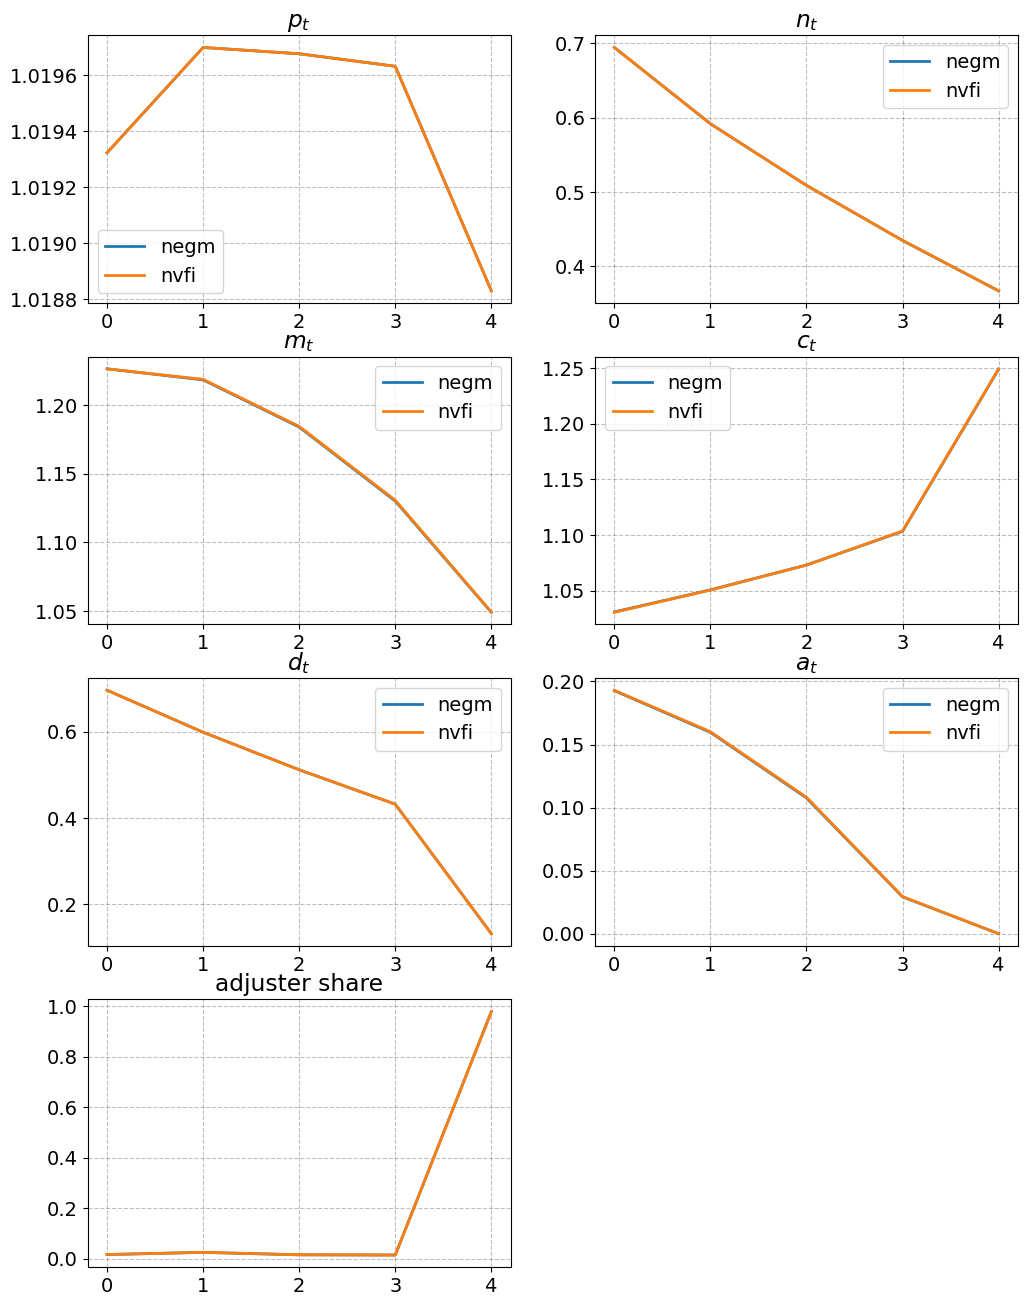

In [11]:
from figs import lifecycle_compare
lifecycle_compare(model_negm,'negm',model_nvfi,'nvfi')

## 8. <a id='toc8_'></a>[Compare life-cycle profiles with VFI](#toc0_)

In [12]:
model_vfi = DurableConsumptionModelClass(name='example_vfi',par={'solmethod':'vfi','T':T,'do_print':True})
model_vfi.precompile_numba() # solve with very coarse grids
model_vfi.solve()
model_vfi.simulate()
model_vfi.save()

numba precompiled in 50.3 secs
 t = 4 solved in 0.1 secs
  w computed in 0.0 secs


  solved keeper problem in 6.8 secs


  solved adjuster problem in 0.3 secs
 t = 3 solved in 7.2 secs
  w computed in 0.0 secs


  solved keeper problem in 6.8 secs


  solved adjuster problem in 0.3 secs
 t = 2 solved in 14.3 secs
  w computed in 0.0 secs


  solved keeper problem in 6.9 secs


  solved adjuster problem in 0.4 secs
 t = 1 solved in 21.6 secs
  w computed in 0.0 secs


  solved keeper problem in 7.0 secs


  solved adjuster problem in 0.4 secs
 t = 0 solved in 29.0 secs
model simulated in 0.1 secs
euler errors calculated in 0.0 secs
utility calculated in 0.0 secs


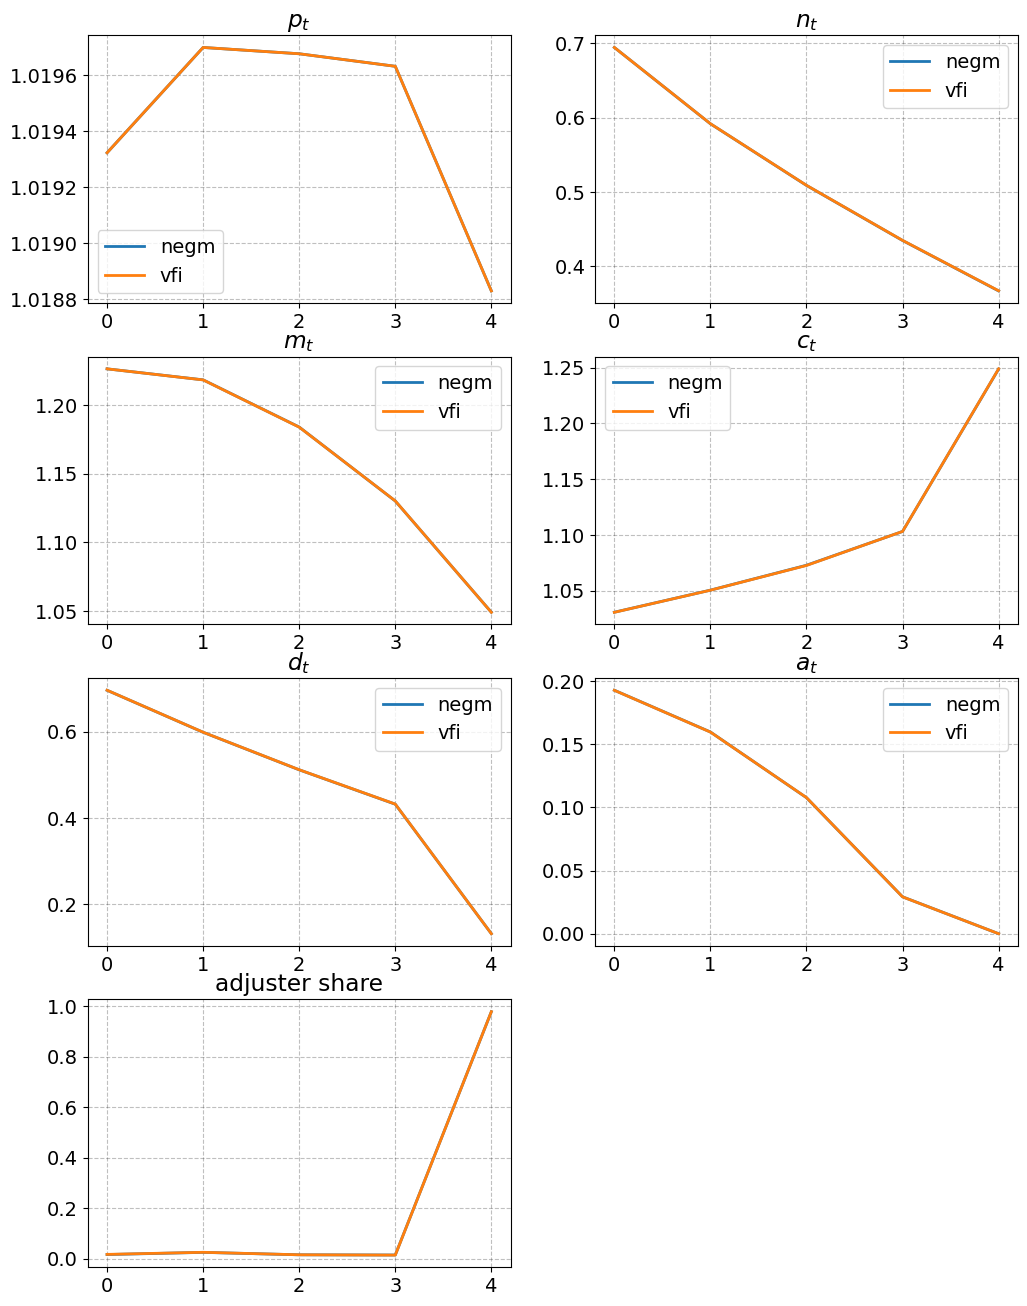

In [13]:
lifecycle_compare(model_negm,'negm',model_vfi,'vfi')